In [11]:
import pandas as pd
data = pd.read_csv('London_cleared.csv')
print(data.info())

missing_per_variable = data.isna().sum()
print(missing_per_variable)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5264 entries, 0 to 5263
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Borough                             5264 non-null   object 
 1   LSOA name                           5264 non-null   object 
 2   LSOA code                           5264 non-null   object 
 3   crime                               5264 non-null   float64
 4   population                          5264 non-null   float64
 5   special_ethnic                      5264 non-null   float64
 6   area_sqm                            5264 non-null   float64
 7   greenspace_ratio                    5264 non-null   float64
 8   access_point_density                5264 non-null   float64
 9   greenspace_access_interaction       5264 non-null   float64
 10  police_coverage_ratio               5264 non-null   float64
 11  NDLI                                5264 no

In [12]:
import geopandas as gpd
import pandas as pd
import os

In [13]:
#Change the numbers into ratio

data['crime'] = data['crime'] / data['population']

data['Rented from Local Authority'] = data['Rented from Local Authority'] / data['households']
data['bedless'] = data['bedless'] / data['households']
data['shared house'] = data['shared house'] / data['households']
data['none'] = data['none'] / data['households']
data.rename(columns={'none': 'no car'}, inplace=True)

data['long term unemployed'] = data['long term unemployed'] / data['residents workable']
data['low level occupation'] = data['low level occupation'] / data['residents workable']
data['less work hours'] = data['less work hours'] / data['residents workable']

data['Lone parent and dependent children'] = data['Lone parent and dependent children'] / data['households']
data['UK and EU14'] = data['UK and EU14'] / data['population']

In [14]:
from sklearn.linear_model import LinearRegression

# Obtain the residuals of NDLI
model = LinearRegression()
model.fit(data[['house mean price']], data['NDLI'])
data['NDLI_residual'] = data['NDLI'] - model.predict(data[['house mean price']])

模型评估结果:
平均绝对误差 (MAE): 0.00
均方误差 (MSE): 0.00
R² 值: 0.58
交叉验证 R² 平均值: 0.27

分类评估指标（将回归问题转换为分类问题）：
准确率 (Accuracy): 71.39%
召回率 (Recall): 85.03%
精确率 (Precision): 65.70%
F1 分数: 0.74

影响犯罪率的前10个变量：
                               Feature  Importance
23                  population_density    0.197208
12                              no car    0.161966
19  Lone parent and dependent children    0.089477
24                   household_density    0.061369
2                             area_sqm    0.050094
7                                 NDLI    0.045032
25                       NDLI_residual    0.040824
10                        shared house    0.036572
22                    house mean price    0.031455
1                       special_ethnic    0.030167
3                     greenspace_ratio    0.029807
8          Rented from Local Authority    0.024306
0                           population    0.021930
18                            teenager    0.019903
21                         UK and EU14    0.

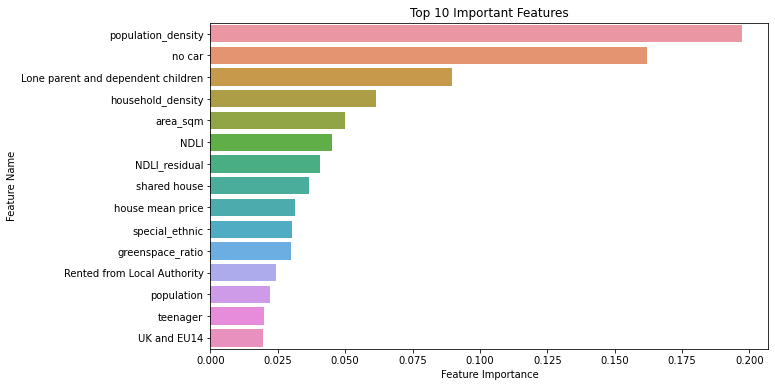

In [10]:
# Simple Random Forest, ignoring interactions between regions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
# Assume data has already been loaded
inner_london_boroughs = [
    'City of London', 'Hackney', 'Islington', 'Tower Hamlets', 'Westminster', 
    'Camden', 'Greenwich', 'Hammersmith and Fulham', 'Kensington and Chelsea',
    'Lambeth', 'Lewisham', 'Southwark', 'Wandsworth'
]

data = data[data['Borough'].isin(inner_london_boroughs)]

# Exclude variables that are not involved in modeling
exclude_columns = ['Borough', 'LSOA name', 'LSOA code']
features = data.drop(columns=exclude_columns + ['crime'])  # As features
target = data['crime']  # Target variable

# Split the dataset into training set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# V-fold cross-validation (default 5 folds)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate regression model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model evaluation results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Cross-Validation R² Average: {np.mean(cv_scores):.2f}")

# Set a threshold to convert regression into a classification problem
threshold = y_train.median()  # Use median of training set as threshold for crime classification
y_test_class = (y_test >= threshold).astype(int)  # Classify values above median as 1 (high crime), otherwise 0
y_pred_class = (y_pred >= threshold).astype(int)

# Compute classification evaluation metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)

print("\nClassification evaluation metrics (converting regression to classification):")
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1 Score: {f1:.2f}")

# Obtain feature importance and extract the top 10 important variables
feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importances.head(15)

print("\nTop 10 variables influencing crime rate:")
print(top_10_features)

# Plot feature importance chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features['Importance'], y=top_10_features['Feature'])
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()



In [49]:
# Manually introduce features of neighboring areas, then use standard machine learning models
# First, import the geographic data file

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import fiona
from pysal.lib import weights
from pysal.explore import esda
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

shapefile_path = "LB_LSOA2021_shp"
layers = fiona.listlayers(shapefile_path)
lsoa_gdfs = [gpd.read_file(shapefile_path, layer=layer)[['lsoa21cd', 'geometry']] for layer in layers]
lsoa_gdf = gpd.GeoDataFrame(pd.concat(lsoa_gdfs, ignore_index=True))

lsoa_gdf['lsoa21cd'] = lsoa_gdf['lsoa21cd'].str.strip()

target_crs = "EPSG:27700"
if lsoa_gdf.crs != target_crs:
    lsoa_gdf = lsoa_gdf.to_crs(target_crs)
    
lsoa_gdf.rename(columns={'lsoa21cd': 'LSOA code'}, inplace=True)

# Define Inner London areas
inner_london_boroughs = [
    'City of London', 'Hackney', 'Islington', 'Tower Hamlets', 'Westminster', 
    'Camden', 'Greenwich', 'Hammersmith and Fulham', 'Kensington and Chelsea',
    'Lambeth', 'Lewisham', 'Southwark', 'Wandsworth'
]

# Filter out data for Inner London
inner_london_data = data[data['Borough'].isin(inner_london_boroughs)]

# Ensure LSOA code is unique
data = data.drop_duplicates(subset=['LSOA code'])
lsoa_gdf = lsoa_gdf.drop_duplicates(subset=['LSOA code'])

# Ensure matching records
data = data[data['LSOA code'].isin(lsoa_gdf['LSOA code'])]
lsoa_gdf = lsoa_gdf[lsoa_gdf['LSOA code'].isin(data['LSOA code'])]

# Ensure all areas are included in GeoDataFrame
lsoa_gdf['LSOA code'] = lsoa_gdf['LSOA code'].str.strip()
data = data.merge(lsoa_gdf[['LSOA code', 'geometry']], on='LSOA code', how='left')

data['LSOA code'] = data['LSOA code'].astype(str).str.strip().str.upper()
lsoa_gdf['LSOA code'] = lsoa_gdf['LSOA code'].astype(str).str.strip().str.upper()

# Sort by LSOA code
lsoa_gdf = lsoa_gdf.sort_values(by='LSOA code').reset_index(drop=True)
data = data.sort_values(by='LSOA code').reset_index(drop=True)

# Ensure index consistency
assert list(lsoa_gdf['LSOA code']) == list(data['LSOA code']), "Data does not match after sorting!"

# Create global spatial weights (including all areas)
w = weights.Queen.from_dataframe(lsoa_gdf, ids='LSOA code')

# Calculate spatial lag variables and retain lag values for Inner London
data['neighbor_crime'] = weights.spatial_lag.lag_spatial(w, data['crime'])
inner_london_data['neighbor_crime'] = inner_london_data['LSOA code'].map(data.set_index('LSOA code')['neighbor_crime'])

# Handle missing values
inner_london_data.fillna(0, inplace=True)

# Prepare training data using only Inner London data
X = inner_london_data.drop(columns=['Borough', 'LSOA name', 'LSOA code', 'crime'])  # Predictors
y = inner_london_data['crime']  # Target variable

# Split training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model performance
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

print("Random Forest:")
print(f"  Mean Squared Error (MSE): {mean_squared_error(y_test, rf_pred):.2f}")
print(f"  R^2 Score: {r2_score(y_test, rf_pred):.2f}")

print("XGBoost:")
print(f"  Mean Squared Error (MSE): {mean_squared_error(y_test, xgb_pred):.2f}")
print(f"  R^2 Score: {r2_score(y_test, xgb_pred):.2f}")

# Extract feature importance
rf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

xgb_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)

print("\nRandom Forest - Top 10 variables affecting crime rate:")
print(rf_feature_importance.head(10))

print("\nXGBoost - Top 10 variables affecting crime rate:")
print(xgb_feature_importance.head(10))

# Importance of Randon forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features - Random Forest')
plt.gca().invert_yaxis()  
plt.show()

# Iportance of Xgboost
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features - XGBoost')
plt.gca().invert_yaxis()
plt.show()

Random Forest:
  均方误差 (MSE): 0.01
  R^2 评分: 0.31
XGBoost:
  均方误差 (MSE): 0.04
  R^2 评分: -1.28

随机森林 - 影响犯罪率的前10个变量:
                               Feature  Importance
26                      neighbor_crime    0.491294
23                  population_density    0.070977
19  Lone parent and dependent children    0.059135
12                              no car    0.043315
2                             area_sqm    0.035857
25                       NDLI_residual    0.032318
24                   household_density    0.022189
18                            teenager    0.020911
21                         UK and EU14    0.018819
7                                 NDLI    0.018199

XGBoost - 影响犯罪率的前10个变量:
                               Feature  Importance
26                      neighbor_crime    0.361019
19  Lone parent and dependent children    0.232194
1                       special_ethnic    0.088937
23                  population_density    0.040204
12                              no car    0.

In [7]:
from sklearn.linear_model import LassoCV

# 1. Perform feature selection using Lasso
def feature_selection_lasso(X, y, alpha=0.1):
    lasso = LassoCV(cv=5, alphas=np.logspace(-4, 0, 50), random_state=42)
    lasso.fit(X, y)
    
    # Identify the indices of non-zero coefficients
    selected_features = np.where(lasso.coef_ != 0)[0]
    print(f"Number of selected features: {len(selected_features)}")
    
    # Filter features
    X_selected = X[:, selected_features]
    selected_feature_names = [feature_names[i] for i in selected_features]
    
    return X_selected, selected_feature_names

feature_names = list(data.drop(columns=['Borough', 'LSOA name', 'LSOA code', 'crime']).columns)

# Prepare regression variables
X = data.drop(columns=['Borough', 'LSOA name', 'LSOA code', 'crime'])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).values  # Ensure numerical values
y = data['crime'].values

# Apply Lasso for feature selection
X, selected_feature_names = feature_selection_lasso(X, y)

# Output the selected feature names
print("Selected feature names:")
print(selected_feature_names)


选择出的特征数量: 19
筛选出的变量名:
['population', 'special_ethnic', 'area_sqm', 'greenspace_ratio', 'greenspace_access_interaction', 'NDLI', 'Rented from Local Authority', 'bedless', 'shared house', 'households', 'no car', 'employment_rate', 'residents workable', 'low level occupation', 'Lone parent and dependent children', 'average deprivation', 'UK and EU14', 'house mean price', 'population_density']


In [16]:
selected_columns = [
    'Borough', 'LSOA name', 'LSOA code', 'crime', 'population', 'special_ethnic', 'area_sqm', 
    'greenspace_ratio', 'greenspace_access_interaction', 'NDLI', 
    'Rented from Local Authority', 'bedless', 'shared house', 'households', 
    'no car', 'employment_rate', 'residents workable', 'low level occupation', 
    'Lone parent and dependent children', 'average deprivation', 'UK and EU14', 
    'house mean price', 'population_density'
]

data_lasso = data[selected_columns]
data_lasso.to_csv('data_lasso.csv', index=False)

In [ ]:
# Geographically Weighted Regression (GWR)

import geopandas as gpd
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from shapely.geometry import Point

data = pd.read_csv('data_lasso.csv')

# Define Inner London areas
inner_london_boroughs = [
    'City of London', 'Hackney', 'Islington', 'Tower Hamlets', 'Westminster', 
    'Camden', 'Greenwich', 'Hammersmith and Fulham', 'Kensington and Chelsea',
    'Lambeth', 'Lewisham', 'Southwark', 'Wandsworth'
]

# Filter out data for Inner London
inner_london_data = data[data['Borough'].isin(inner_london_boroughs)]

# Ensure LSOA code is unique
data = data.drop_duplicates(subset=['LSOA code'])
lsoa_gdf = lsoa_gdf.drop_duplicates(subset=['LSOA code'])

# Ensure matching records
data = data[data['LSOA code'].isin(lsoa_gdf['LSOA code'])]
lsoa_gdf = lsoa_gdf[lsoa_gdf['LSOA code'].isin(data['LSOA code'])]

# Ensure all areas are included in GeoDataFrame
lsoa_gdf['LSOA code'] = lsoa_gdf['LSOA code'].str.strip()
data = data.merge(lsoa_gdf[['LSOA code', 'geometry']], on='LSOA code', how='left')

data['LSOA code'] = data['LSOA code'].astype(str).str.strip().str.upper()
lsoa_gdf['LSOA code'] = lsoa_gdf['LSOA code'].astype(str).str.strip().str.upper()

# Sort by LSOA code
lsoa_gdf = lsoa_gdf.sort_values(by='LSOA code').reset_index(drop=True)
data = data.sort_values(by='LSOA code').reset_index(drop=True)

# Ensure index consistency
assert list(lsoa_gdf['LSOA code']) == list(data['LSOA code']), "Data does not match after sorting!"

# Convert geometry information to coordinates (longitude and latitude)
lsoa_gdf['centroid'] = lsoa_gdf['geometry'].centroid
lsoa_gdf['longitude'] = lsoa_gdf['centroid'].apply(lambda p: p.x)
lsoa_gdf['latitude'] = lsoa_gdf['centroid'].apply(lambda p: p.y)

# Retrieve coordinate information for Inner London areas
inner_london_data = inner_london_data.merge(lsoa_gdf[['LSOA code', 'longitude', 'latitude']], on='LSOA code', how='left')

# Prepare data for GWR model
X = inner_london_data.drop(columns=['Borough', 'LSOA name', 'LSOA code', 'crime'])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).values  # Ensure all variables are numeric

y = inner_london_data['crime'].values.reshape(-1, 1)

# Use coordinate information for Geographically Weighted Regression
coords = inner_london_data[['longitude', 'latitude']].values

# Split into X, y, and coords
X_ = data.iloc[:, :-3].values  # First n columns as X
y = data['crime'].values.reshape(-1, 1)  # Last column as y
coords = data[['coord_x', 'coord_y']].values  # Second to last and third to last columns as coords

# Check for consistency
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"coords shape: {coords.shape}")

assert X.shape[0] == y.shape[0] == coords.shape[0], "Data length mismatch!"


In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Print dimensional information before removal
print("Before removal:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("coords shape:", coords.shape)

# Convert data to DataFrame for easier processing
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=['target'])
coords_df = pd.DataFrame(coords, columns=['longitude', 'latitude'])

# Merge data to facilitate synchronized deletion
combined_df = pd.concat([X_df, y_df, coords_df], axis=1)

# Remove completely duplicate rows
combined_df = combined_df.drop_duplicates()

# Separate cleaned data
X_cleaned = combined_df.iloc[:, :-3].values  # First n-3 columns are X
y_cleaned = combined_df['target'].values     # Target column
coords_cleaned = combined_df.iloc[:, -2:].values  # Last two columns are coordinates

# Print dimensional information after removal to ensure consistency
print("After removal:")
print("X shape:", X_cleaned.shape)
print("y shape:", y_cleaned.shape)
print("coords shape:", coords_cleaned.shape)

# Ensure the number of rows is consistent across all datasets
assert X_cleaned.shape[0] == y_cleaned.shape[0] == coords_cleaned.shape[0], "Dataset inconsistency still exists"

# Assign cleaned data back to original variables
X, y, coords = X_cleaned, y_cleaned, coords_cleaned

valid_rows = ~np.isnan(coords).any(axis=1)
coords = coords[valid_rows]
X = X[valid_rows]
y = y[valid_rows]

# Select bandwidth (automatically selecting optimal bandwidth)
selector = Sel_BW(coords, y, X)
optimal_bw = selector.search()

print(f"Optimal bandwidth: {optimal_bw}")

# Run Geographically Weighted Regression (GWR)
gwr_model = GWR(coords, y, X, optimal_bw, kernel='gaussian', fixed=False)
gwr_results = gwr_model.fit()

# Print regression results
print("GWR Results Summary:")
print(gwr_results.summary())

# Extract regression coefficients
coefficients = pd.DataFrame(gwr_results.params, columns=['Intercept'] + list(inner_london_data.drop(columns=['Borough', 'LSOA name', 'LSOA code', 'crime']).columns))
coefficients['LSOA code'] = inner_london_data['LSOA code'].values

# Calculate model performance metrics
print(f"\nGWR Model Performance:")
print(f"R²: {gwr_results.R2:.4f}")
print(f"Adjusted R²: {gwr_results.adj_R2:.4f}")
print(f"AIC: {gwr_results.aic:.4f}")

# Visualization of results: examining variable influence
coefficients_mean = coefficients.mean().drop('LSOA code').sort_values(ascending=False)
print("\nVariables ranked by importance:")
print(coefficients_mean)

# Merge regression coefficients back into the Inner London dataset
inner_london_data = inner_london_data.merge(coefficients, on='LSOA code', how='left')
